### 루브릭
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
    - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
    - 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
    - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.


In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Step 1. 데이터 수집하기


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
data.sample(10)

,headlines,text
43414,Website publishes fake news on Pamela Anderson...,A website named ABCNews-us published a report ...
24469,My next target is to end prostitution in Delhi...,Delhi Commission for Women (DCW) chief Swati M...
47371,RGV interrogated by Hyd police over obscenity ...,Filmmaker Ram Gopal Varma has been interrogate...
20034,Guard arrested for raping 16-yr-old for 3 mont...,Gurugram police on Friday arrested a security ...
2524,Up and about: Hrithik shares pic post dad's ca...,Hrithik Roshan took to Twitter to share a pict...
82932,"New trailer of Ranbir, Katrina's Jagga Jasoos ...",A new trailer of the Ranbir Kapoor and Katrina...
86717,'How peacocks have sex?' among most searched o...,After Rajasthan High Court judge Mahesh Chandr...
60250,'Julie 2' based on real life actress' story: P...,"Pahlaj Nihalani, the presenter of the erotic t..."
94568,How is life after retirement? A few cookies ca...,Aimed at understanding what people would love ...
93072,"Trailer of Kriti Sanon, Sushant Singh Rajput's...",The official trailer of the Kriti Sanon and Su...


Step 2. 데이터 전처리하기 (추상적 요약)

1) 중복

2) 널

3) 불용어
+ Empty check

4) 샘플 최대 길이

5) 시작 토큰, 종료 토큰

6) 훈련, 테스트 분리

7) 정수 인코딩
+ Empty check

8) 패딩


In [4]:
# 중복 확인
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [5]:
# text 열 중복 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾼다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
# Null값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
# 텍스트 정규화
## 약어 정규화 - 같은 의미를 가지면 같은 값으로 통일
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
# nltk 불용어
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

텍스트(본문)에 대해 전처리

In [10]:
clean_text = []
# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [12]:
# empty 확인하고 Null로 대체
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

4) 샘플 최대 길이

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


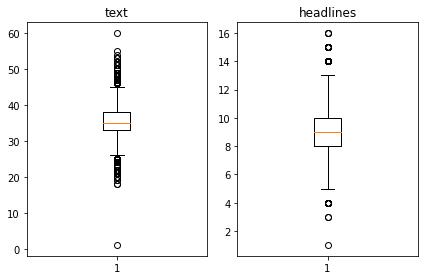

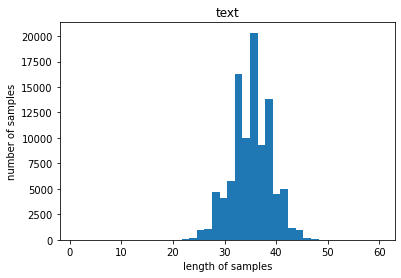

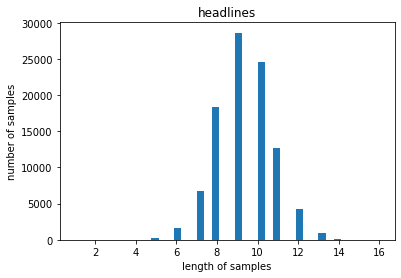

In [14]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']] # 하나의 문장에 대해 단어로 쪼개서 
headlines_len = [len(s.split()) for s in data['headlines']] # 문장 내 단어 갯수를 길이로 지정함

# 단어갯수 수열에서 가장 작은 값, 가장 큰 값, 평균을 구함
print('텍스트의 최소 길이 : {}'.format(np.min(text_len))) 
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

# plot 만들기
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# 전체 샘플 중 길이를 지정했을 때 데이터에서 샘플의 비율
## 비율이 적당한지 파악
## 그 길이 이상은 지움

text_max_len = 42
headlines_max_len = 12

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 42 이하인 샘플의 비율: 0.9750305002033347
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [16]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 94754


시작토큰 & 종료토큰
- 디코더의 input으로 사용되는 헤드라인은 시작과 종료를 알리는 토큰을 넣어야 함
- 토큰 추가 후, 학습 때 따로 사용하기 위해 데이터를 분리해서 저장한다.

In [17]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [18]:
# 훈련에 사용하기 위해 넘피 어레이로 바꿔줌
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

Train / Test 분리
- indices를 만들어서 순서 셔플링
- 셔플링 후 비율만큼 나눔

In [19]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[67039 11593 11050 ... 42385 33175 11648]


In [20]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [21]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18950


In [22]:
encoder_input_train = encoder_input[:-n_of_val] # -1을 하면 맨뒤 값 한개만 제외, -2,-3...-n_of_val개까지 제외
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:] # -n_of_val(전체에서 -n_of_val한 인덱스)부터 시작
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


정수 인코딩
- vocab 만들기
    - 사전이 만들어지는 원리 
        - 문장을 단어로 분리 후
        - 자주 사용되는 단어를 기준으로 sorting 하여 남김

In [23]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [24]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67951
등장 빈도가 6번 이하인 희귀 단어의 수: 46330
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21621
단어 집합에서 희귀 단어의 비율: 68.18148371620727
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5661652337851373


In [25]:
src_vocab = total_cnt - rare_cnt
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [26]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3344, 4962, 1641, 2487, 124, 5405, 2000, 173, 1324, 10678, 32, 70, 637, 762, 1561, 819, 70, 2674, 104, 30, 1, 513, 635, 2031, 11542, 14416, 1136, 1168, 1387, 372, 404, 149, 372, 494], [428, 292, 1344, 794, 11543, 9558, 13907, 306, 1793, 600, 23, 216, 539, 18948, 262, 1223, 1520, 9558, 13907, 333, 1848, 1203, 20184, 262, 17063, 11543, 9558, 13907, 333, 11877, 686, 1223], [152, 15, 118, 47, 88, 1, 425, 140, 1461, 669, 1638, 505, 758, 415, 1056, 1013, 2855, 382, 415, 11259, 1097, 448, 14417, 1013, 4, 12, 1199, 423, 579, 359, 20, 382, 1]]


In [27]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [28]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29571
등장 빈도가 5번 이하인 희귀 단어의 수: 19379
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10192
단어 집합에서 희귀 단어의 비율: 65.53380000676339
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.79100568258606


In [29]:
tar_vocab = total_cnt - rare_cnt
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3214, 4718, 771, 2457, 182, 1641, 4, 1757], [1, 297, 998, 6679, 7995, 339, 569, 3918], [1, 1257, 268, 11, 115, 2813, 45, 289, 22, 1686, 40], [1, 433, 1124, 16, 35, 273, 5, 2814, 755, 2164], [1, 9, 473, 58, 3, 3696, 110, 93, 1344, 1316, 4, 191, 1152]]
target
decoder  [[3214, 4718, 771, 2457, 182, 1641, 4, 1757, 2], [297, 998, 6679, 7995, 339, 569, 3918, 2], [1257, 268, 11, 115, 2813, 45, 289, 22, 1686, 40, 2], [433, 1124, 16, 35, 273, 5, 2814, 755, 2164, 2], [9, 473, 58, 3, 3696, 110, 93, 1344, 1316, 4, 191, 1152, 2]]


In [30]:
# sos, eos 토큰만 남은 경우 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75803
훈련 레이블의 개수 : 75803
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


패딩하기

In [31]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [32]:
encoder_input_train[:5]

array([[ 3344,  4962,  1641,  2487,   124,  5405,  2000,   173,  1324,
        10678,    32,    70,   637,   762,  1561,   819,    70,  2674,
          104,    30,     1,   513,   635,  2031, 11542, 14416,  1136,
         1168,  1387,   372,   404,   149,   372,   494,     0,     0,
            0,     0,     0,     0,     0,     0],
       [  428,   292,  1344,   794, 11543,  9558, 13907,   306,  1793,
          600,    23,   216,   539, 18948,   262,  1223,  1520,  9558,
        13907,   333,  1848,  1203, 20184,   262, 17063, 11543,  9558,
        13907,   333, 11877,   686,  1223,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [  152,    15,   118,    47,    88,     1,   425,   140,  1461,
          669,  1638,   505,   758,   415,  1056,  1013,  2855,   382,
          415, 11259,  1097,   448, 14417,  1013,     4,    12,  1199,
          423,   579,   359,    20,   382,     1,     0,     0,     0,
            0,     0,     0,     0,     0,    

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
- 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.



In [33]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) # inital_state로 state_h, state_c를 준다.

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2767488     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=10) # 50 시간이 너무 오래걸려서 변경

Epoch 1/10
297/297 [==============================] - 203s 616ms/step - loss: 5.6455 - val_loss: 5.2579
Epoch 2/10
297/297 [==============================] - 182s 612ms/step - loss: 5.0823 - val_loss: 4.8806
Epoch 3/10
297/297 [==============================] - 181s 609ms/step - loss: 4.7131 - val_loss: 4.6200
Epoch 4/10
297/297 [==============================] - 181s 609ms/step - loss: 4.4453 - val_loss: 4.4289
Epoch 5/10
297/297 [==============================] - 180s 605ms/step - loss: 4.2479 - val_loss: 4.2772
Epoch 6/10
297/297 [==============================] - 180s 605ms/step - loss: 4.0869 - val_loss: 4.1915
Epoch 7/10
297/297 [==============================] - 180s 605ms/step - loss: 3.9466 - val_loss: 4.0927
Epoch 8/10
297/297 [==============================] - 179s 601ms/step - loss: 3.8224 - val_loss: 4.0203
Epoch 9/10
297/297 [==============================] - 181s 611ms/step - loss: 3.7094 - val_loss: 3.9361
Epoch 10/10
297/297 [==============================] - 179s 604m

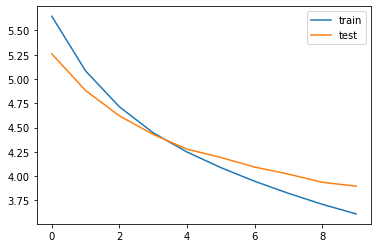

In [35]:
# loss와 val_loss 비교
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

인퍼런스 모델 구현

In [36]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [37]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [38]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.



In [39]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [40]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : jay smith year old high school dropout cryptocurrency trader seen portfolio rise past months put order tesla even know drive said smith retail investors take notice advice copy trades online brokerage 
실제 요약 : yr old cryptocurrency trader stock up in months 
예측 요약 :  billionaire buys billionaire for crore


원문 : bjp sunday organised mann ki baat chai ke saath program gujarat sunday wherein party workers listened prime minister narendra modi radio address tea residents party leaders including bjp chief amit shah finance minister arun jaitley launched programme polling booths across state 
실제 요약 : bjp organises mann ki baat ke program in guj 
예측 요약 :  pm modi releases new party for the first time


원문 : prime minister narendra modi tuesday met fishermen affected cyclone ockhi tamil nadu kanyakumari also visited coastal villages cyclone lakshadweep kerala thiruvananthapuram damaged properties hundreds fishermen reported died several others missing ockhi struck southern coast november

Step 5. Summa을 이용해서 추출적 요약해보기
- 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.
- Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [50]:
!pip list | grep summa

summa                         1.2.0


In [55]:
import requests
from summa.summarizer import summarize

In [56]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data_1 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [58]:
for idx, (head, text) in enumerate(zip(data_1['headlines'], data_1['text'])):
    if idx == 50:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("추출적 요약 :", summarize(text, ratio=0.40)) # ratio에 따라 추출 여부가 차이남
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee of bill p

### 추상적 요약과 추출적 요약 비교
#### 문법완성도 측면과 핵심단어 포함

|분류 | 핵심단어포함 | 문법 완성도 |
|------|---|---|
|Abstracive(seq2seq,att)| X | X |
|Extractive(summa)| O | X |


<Extractive - case1>
    
- 원문 : Railway police has rescued a woman travelling on a train in Chennai who got her leg stuck inside the commode of a toilet. After being caught inside the commode hole, she struggled to remove her leg and following failed attempts, she shouted for help, reports said. Railway police used a cutter to pry open the commode and freed her leg.
    
- 실제 요약 : Railway police rescues woman with leg stuck in train toilet
    
- 추출적 요약 : Railway police has rescued a woman travelling on a train in Chennai who got her leg stuck inside the commode of a toilet.

>   실제 요약보다 긴 경우가 많고, 이 경우 외에도 맨 첫 문장을 선택하는 경우가 많았음
    
>   문법완성도: 0
    
>   핵심단어: 0 

<Extractive - case2>
- 원문 : The Indian Space Research Organisation on Wednesday unveiled Human Space Flight Centre in Bengaluru for its Ã¢ÂÂ¹10,000-crore manned space mission 'Gaganyaan' scheduled for 2021. ISRO said the centre will be responsible for development of engineering systems for crew survival in space and crew selection and training. It'll also pursue activities for sustained human space flight missions, ISRO added.

- 실제 요약 : ISRO unveils Bengaluru centre for manned space mission 

- 추출적 요약 : It'll also pursue activities for sustained human space flight missions, ISRO added.

>  마지막 문장을 추출하였으나 핵심문장이 아님.
    
>  문법완성도: 0
    
>  핵심단어: x -> in Bengaluru 장소이므로 필요


<Abstracive - case1>

- 원문 : akshay kumar play villain upcoming kamal haasan starrer indian per reports earlier reports suggested film director shankar offered ajay devgn pivotal role cop film actor turned due prior commitments akshay previously played villain shankar directorial opposite rajinikanth  

- 실제 요약 : akshay to play villain in kamal haasan indian reports 

- 예측 요약 :  akshay to star in akshay kumar report

>   주연이 나니라 악당 역할을 맞게 되는 것인데 틀리게 말하고 있음.
    
>   문법완성도: X
    
>   핵심단어: X -> villain 이 없음

<Abstracive - case2>

- 원문 : ajay devgn starrer raid become third highest opening day grosser earning crore first day sanjay leela bhansali padmaavat highest opener first day earnings crore top five highest opening day grossing films also include pad man sonu ke titu ki sweety pari 

- 실제 요약 : ajay devgn raid becomes rd highest opener of 

- 예측 요약 :  st highest highest paid highest ever in film list

>   같은 단어를 반복함, 이는 소프트맥스 값에서 서칭 알고리즘을 적용하지 않아서 나타나는 문제임

>   위와 같이 틀린 내용으로 예측함, 추측으로 st는 first의 약어같은데 그렇다면 third의 rd가 사용되어야함.
    
>   문법완성도: X -> 같은 단어 반복
    
>   핵심단어: X -> 주요 단어들이 대부분 빠졌음, ajay devgn, raid, rd, opener 없음

# 회고

- Seq2seq + attention 모델로 문장 요약 모델을 만들었음
    - 뉴스 본문을 소스로 헤드라인을 타겟으로하여 학습
    - 학습이 잘 안된 것인지 모르겠지만 결과가 그렇게 좋아보이지 않음
    - score를 통해 채점해보면 더 좋을 것 같음
- Summa 패키지로 추출적 요약을 수행해봄
    - 인자인 ratio, word에 따라 추출의 정도가 차이나므로 조절이 필요함
    - 여러 문장을 추출하는 경우에는 떨어져있는 문장끼리 합치므로 매끄럽지 않을 수 있을 것 같음

- 추가로 공부할 부분
    - 텐서플로 모델의 save, checkpoint 
    - val 환경에서 가장 좋은 모델을 어떻게 저장할까?